Disini kita akan membangun model clustering menggunakan metode K-Means pada dataset "Wholesale customer data". Masalah yang ditemui adalah bagaimana cara mengelompokkan pelanggan grosir berdasarkan pola pembelian mereka agar perusahaan dapat menyusun strategi pemasaran yang lebih tepat sasaran? Berikut merupakan langkah-langkahnya

Import Dataset

In [ ]:
import csv

def load_data(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file, delimiter=';')
        next(reader)  # Lewati header
        data = []
        for row in reader:
            features = list(map(float, row[2:]))  # Ambil kolom numerik
            data.append(features)
    return data

data = load_data('Wholesale customers data.csv')
print(f"Jumlah data: {len(data)} baris, {len(data[0])} fitur per baris")


Jumlah data: 440 baris, 6 fitur per baris


Statistika deskriptif

In [ ]:
def describe_statistics(data, labels):
    from math import sqrt

    print(f"{'Fitur':<18} {'Min':>10} {'Max':>10} {'Mean':>10} {'Std Dev':>10}")
    print("-" * 60)

    for i, label in enumerate(labels):
        col = [row[i] for row in data]
        n = len(col)
        min_val = min(col)
        max_val = max(col)
        mean = sum(col) / n
        std = sqrt(sum((x - mean) ** 2 for x in col) / n)

        print(f"{label:<18} {min_val:10.2f} {max_val:10.2f} {mean:10.2f} {std:10.2f}")

# Contoh penggunaan
labels = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
describe_statistics(data, labels)


Fitur                     Min        Max       Mean    Std Dev
------------------------------------------------------------
Fresh                    3.00  112151.00   12000.30   12632.95
Milk                    55.00   73498.00    5796.27    7371.99
Grocery                  3.00   92780.00    7951.28    9492.36
Frozen                  25.00   60869.00    3071.93    4849.15
Detergents_Paper         3.00   40827.00    2881.49    4762.43
Delicassen               3.00   47943.00    1524.87    2816.90


Menemukan missing value

In [ ]:
import pandas as pd

df = pd.read_csv('Wholesale customers data.csv', sep=';')
print(df.isnull().sum())

# Atau total seluruh missing value
print(f"Total missing values: {df.isnull().sum().sum()}")


Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64
Total missing values: 0


Mendeteksi outlier

In [ ]:
def detect_outliers_zscore(data, threshold=3):
    outliers = []
    for i in range(len(data[0])):  # untuk setiap fitur
        col = [row[i] for row in data]
        mean = sum(col) / len(col)
        std = (sum((x - mean) ** 2 for x in col) / len(col)) ** 0.5
        for idx, val in enumerate(col):
            z = (val - mean) / std
            if abs(z) > threshold:
                outliers.append((idx, i, val))
    return outliers

outliers = detect_outliers_zscore(data)
print(f"Jumlah outlier terdeteksi: {len(outliers)}")


Jumlah outlier terdeteksi: 43


Visualisasi boxplot untuk menampilkan outlier

<ipython-input-6-1479643783>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(transposed, labels=labels, patch_artist=True, boxprops=dict(facecolor='lightcoral'))


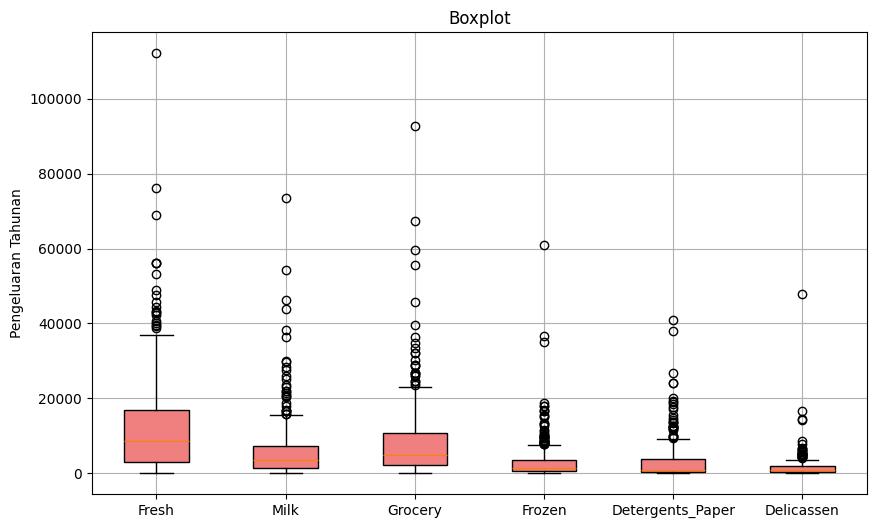

In [ ]:
import matplotlib.pyplot as plt

labels = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
transposed = list(zip(*data))

plt.figure(figsize=(10, 6))
plt.boxplot(transposed, labels=labels, patch_artist=True, boxprops=dict(facecolor='lightcoral'))
plt.title('Boxplot')
plt.ylabel('Pengeluaran Tahunan')
plt.grid(True)
plt.show()


Menghandle outlier dengan winsorization karena untuk mengurangi pengaruh outlier tanpa membuang data dikarenakan isi data relatif kecil

In [ ]:
def winsorize(data, lower_percent=5, upper_percent=95):
    capped = []
    for i in range(len(data[0])):
        col = [row[i] for row in data]
        sorted_col = sorted(col)
        lower = sorted_col[int(len(col) * lower_percent / 100)]
        upper = sorted_col[int(len(col) * upper_percent / 100)]
        capped.append([min(max(x, lower), upper) for x in col])
    return [list(row) for row in zip(*capped)]

winsorized_data = winsorize(data)
print(f"Contoh baris setelah winsorization:\n{winsorized_data[0]}")


Contoh baris setelah winsorization:
[12669.0, 9656.0, 7561.0, 214.0, 2674.0, 1338.0]


Visualisasi boxplot setelah winsorization

<ipython-input-8-1670356643>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(transposed_winsor, labels=labels, patch_artist=True, boxprops=dict(facecolor='lightgreen'))


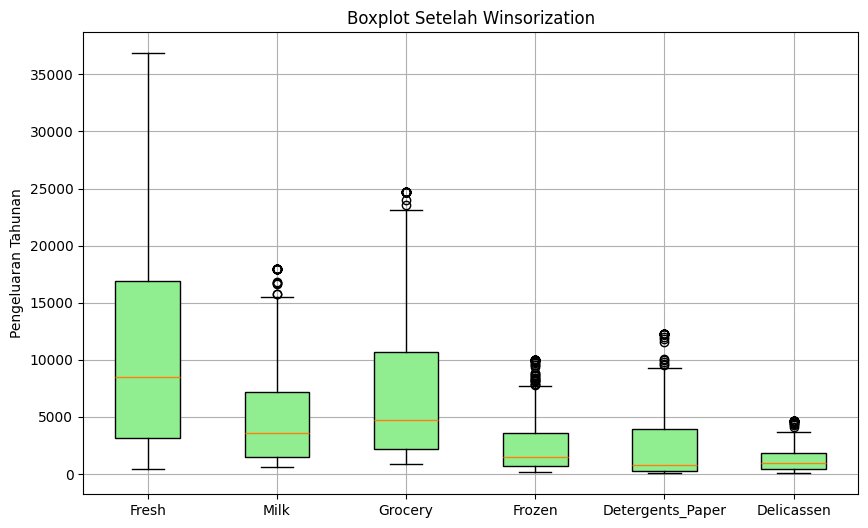

In [ ]:
transposed_winsor = list(zip(*winsorized_data))

plt.figure(figsize=(10, 6))
plt.boxplot(transposed_winsor, labels=labels, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Boxplot Setelah Winsorization')
plt.ylabel('Pengeluaran Tahunan')
plt.grid(True)
plt.show()


Normalisasi skala data menggunakan min max scaler untuk menormalkan skala antar fitur

In [ ]:
def min_max_scale(data):
    scaled = []
    for i in range(len(data[0])):
        col = [row[i] for row in data]
        min_val = min(col)
        max_val = max(col)
        scaled.append([(x - min_val) / (max_val - min_val) for x in col])
    return [list(row) for row in zip(*scaled)]

normalized_data = min_max_scale(winsorized_data)
print(f"Contoh data setelah normalisasi:\n{normalized_data[0]}")


Contoh data setelah normalisasi:
[0.336571177697289, 0.5214639198987225, 0.28116877672507756, 0.007805372529143436, 0.21474411716307387, 0.27926348092941694]


Implementasi K-Means

Algoritma K-Means berusaha mencari posisi centroid yang meminimalkan jarak total ke semua titik dalam cluster.

Proses terus berulang hingga konvergen (centroid tidak berubah) atau mencapai batas iterasi.

In [ ]:
import random
import math

def euclidean(p1, p2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def init_centroids(data, k):
    return random.sample(data, k)

def assign_clusters(data, centroids):
    clusters = [[] for _ in centroids]
    for point in data:
        distances = [euclidean(point, centroid) for centroid in centroids]
        idx = distances.index(min(distances))
        clusters[idx].append(point)
    return clusters

def update_centroids(clusters):
    new_centroids = []
    for cluster in clusters:
        if cluster:
            new_centroids.append([sum(dim)/len(dim) for dim in zip(*cluster)])
    return new_centroids

def kmeans(data, k, max_iter=100):
    centroids = init_centroids(data, k)
    for _ in range(max_iter):
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(clusters)
        if new_centroids == centroids:
            break
        centroids = new_centroids
    return centroids, clusters


Evaluasi menggunakan WCSS untuk mengukur seberapa rapat clusternya

In [ ]:
def compute_wcss(centroids, clusters):
    wcss = 0
    for i in range(len(clusters)):
        for point in clusters[i]:
            wcss += euclidean(point, centroids[i]) ** 2
    return wcss


WCSS mengukur “rapatnya” titik-titik dalam satu cluster. Semakin kecil WCSS, semakin mirip anggota-anggota di cluster tersebut.
Dengan membandingkan WCSS dari berbagai nilai K, kita bisa menentukan jumlah cluster yang optimal berdasarkan metode elbow.

Eksperimen inisiasi beberapa K

In [ ]:
results = []

for k in range(2, 7):
    centroids, clusters = kmeans(normalized_data, k)
    wcss = compute_wcss(centroids, clusters)
    results.append((k, wcss))
    print(f"K = {k}, WCSS = {wcss:.4f}")


K = 2, WCSS = 131.2897
K = 3, WCSS = 102.9281
K = 4, WCSS = 90.6150
K = 5, WCSS = 78.5781
K = 6, WCSS = 71.0733


Berdasarkan hasil WCSS, jumlah cluster optimal kemungkinan berada di antara 3 atau 4.

Visualisasi elbow method

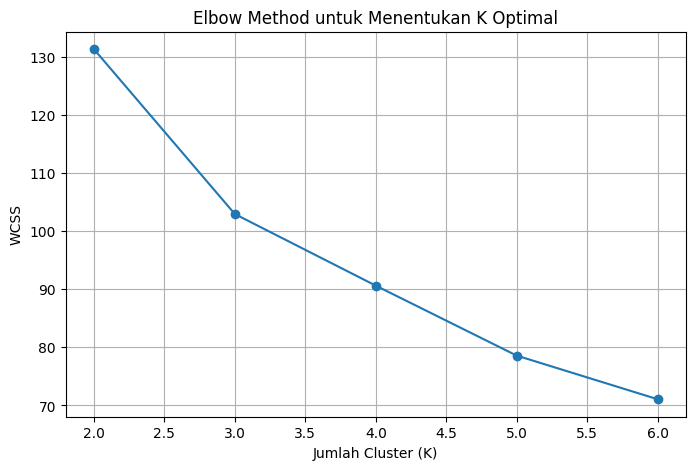

In [ ]:
ks = [k for k, _ in results]
wcss_values = [wcss for _, wcss in results]

plt.figure(figsize=(8, 5))
plt.plot(ks, wcss_values, marker='o', linestyle='-')
plt.title('Elbow Method untuk Menentukan K Optimal')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


Interpretasi isi cluster

In [ ]:
def summarize_clusters(clusters, labels):
    for i, cluster in enumerate(clusters):
        print(f"\nCluster {i} - Jumlah anggota: {len(cluster)}")
        for j, label in enumerate(labels):
            feature_avg = sum(point[j] for point in cluster) / len(cluster)
            print(f"{label:<18}: {feature_avg:.3f}")

labels = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
summarize_clusters(clusters, labels)



Cluster 0 - Jumlah anggota: 49
Fresh             : 0.876
Milk              : 0.279
Grocery           : 0.233
Frozen            : 0.466
Detergents_Paper  : 0.077
Delicassen        : 0.466

Cluster 1 - Jumlah anggota: 185
Fresh             : 0.226
Milk              : 0.098
Grocery           : 0.098
Frozen            : 0.135
Detergents_Paper  : 0.058
Delicassen        : 0.134

Cluster 2 - Jumlah anggota: 62
Fresh             : 0.112
Milk              : 0.456
Grocery           : 0.586
Frozen            : 0.097
Detergents_Paper  : 0.529
Delicassen        : 0.177

Cluster 3 - Jumlah anggota: 31
Fresh             : 0.264
Milk              : 0.850
Grocery           : 0.932
Frozen            : 0.209
Detergents_Paper  : 0.891
Delicassen        : 0.502

Cluster 4 - Jumlah anggota: 56
Fresh             : 0.320
Milk              : 0.134
Grocery           : 0.100
Frozen            : 0.758
Detergents_Paper  : 0.041
Delicassen        : 0.238

Cluster 5 - Jumlah anggota: 57
Fresh             : 0.248
M

Cluster 0 – Low Spender Segment
Anggota: 187 pelanggan (terbesar) Ciri: Semua kategori sangat rendah Kemungkinan: Pelanggan kecil atau pemula, seperti kios kecil atau individu Strategi:

Tawarkan paket hemat untuk mendorong pembelian rutin

Program loyalitas atau diskon minimum pembelian

Cluster 1 – High All-Around Spenders
Anggota: 17 pelanggan Ciri: Pengeluaran sangat tinggi di hampir semua kategori Kemungkinan: Supermarket besar, hotel, atau pelanggan VIP Strategi:

Tawarkan kontrak eksklusif atau harga grosir khusus

Layanan prioritas dan pengiriman gratis untuk memperkuat relasi

Cluster 2 – Delicacy-Oriented Buyers
Anggota: 58 pelanggan Ciri: Sedang di semua kategori, tapi tinggi di Delicassen Kemungkinan: Kafe, toko roti, bisnis makanan eksklusif Strategi:

Promosi bundling untuk Delicassen + Milk atau Grocery

Highlight produk berkualitas tinggi dan premium

Cluster 3 – Frozen Product Dominant
Anggota: 50 pelanggan Ciri: Sangat tinggi di Frozen, sedang di Fresh, lainnya rendah Kemungkinan: Distributor makanan beku, katering makanan siap saji Strategi:

Penawaran khusus untuk pembelian dalam jumlah besar Frozen

Kemudahan cold-chain logistics dan pengiriman cepat

Cluster 4 – Fresh-Dominant Buyers
Anggota: 55 pelanggan Ciri: Sangat tinggi di Fresh, rendah di lainnya Kemungkinan: Restoran, pasar sayur besar Strategi:

Penawaran eksklusif bahan segar harian

Notifikasi stok dan promosi produk musiman

Cluster 5 – Retailers of Grocery & Paper
Anggota: 73 pelanggan Ciri: Tinggi di Grocery, Milk, Detergents_Paper Kemungkinan: Minimarket atau toko kelontong Strategi:

Paket grosir Grocery + Detergents

Promosi khusus saat awal bulan atau musim liburan

Implementasi DBSCAN

In [ ]:
def region_query(data, point_idx, eps):
    return [i for i, p in enumerate(data) if euclidean(data[point_idx], p) <= eps]

def expand_cluster(data, labels, point_idx, neighbors, cluster_id, eps, min_pts):
    labels[point_idx] = cluster_id
    i = 0
    while i < len(neighbors):
        idx = neighbors[i]
        if labels[idx] == -1:
            labels[idx] = cluster_id
        elif labels[idx] is None:
            labels[idx] = cluster_id
            more_neighbors = region_query(data, idx, eps)
            if len(more_neighbors) >= min_pts:
                neighbors += more_neighbors
        i += 1

def dbscan(data, eps, min_pts):
    labels = [None] * len(data)
    cluster_id = 0
    for i in range(len(data)):
        if labels[i] is not None:
            continue
        neighbors = region_query(data, i, eps)
        if len(neighbors) < min_pts:
            labels[i] = -1
        else:
            expand_cluster(data, labels, i, neighbors, cluster_id, eps, min_pts)
            cluster_id += 1
    return labels

dbscan_labels = dbscan(normalized_data, eps=0.2, min_pts=5)


Visualisasi hasil clustering (perbandingan K-Means dan DBSCAN)

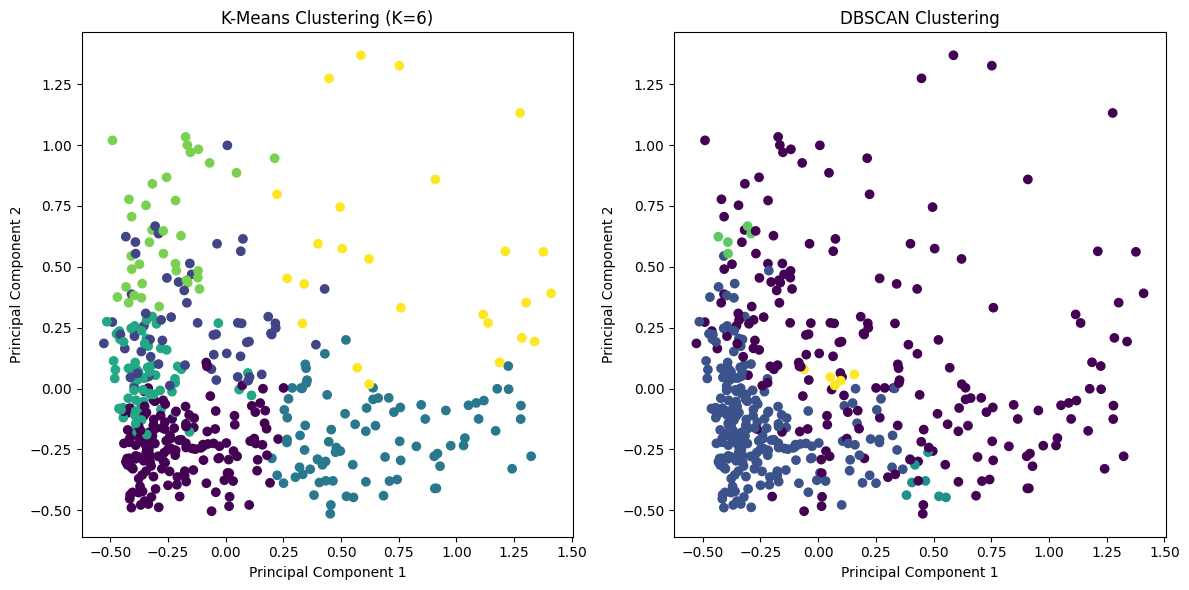

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Since we have high-dimensional data, we can use PCA for dimensionality reduction
from sklearn.decomposition import PCA

# Convert the list of lists to a NumPy array
normalized_data_np = np.array(normalized_data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_data_np)

# Plot K-Means results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)=
# Need to re-run K-Means to get cluster assignments for visualization
# Using the last 'k' value from the previous K-Means run (k=6 in this case)
# You might want to choose an optimal K based on the Elbow method result
optimal_k = 6 # Or choose based on your Elbow plot analysis
kmeans_centroids, kmeans_clusters_list = kmeans(normalized_data, optimal_k)
kmeans_labels = []
for i, cluster in enumerate(kmeans_clusters_list):
    for point in cluster:
        # Find the index of the point in the original normalized_data
        # This is a bit inefficient, a better approach would be to store original indices
        try:
            # Compare the point (list) with lists in normalized_data
            original_index = next(j for j, data_point in enumerate(normalized_data) if data_point == list(point))
            kmeans_labels.append((original_index, i))
        except StopIteration:
             # Handle cases where the point is not found
            pass


# Sort labels by original index to match the order of principal_components
kmeans_labels.sort(key=lambda x: x[0])
kmeans_cluster_assignments = [label[1] for label in kmeans_labels]


plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans_cluster_assignments, cmap='viridis', marker='o')
plt.title(f'K-Means Clustering (K={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot DBSCAN results
plt.subplot(1, 2, 2)
# Ensure dbscan_labels is defined and is a list or array of cluster assignments for each data point
# Assuming dbscan_labels is already computed and available from a previous cell
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()